# Animal Recognition in Tensorflow
* This is a general guide on how to perform every step of development for a CNN built for categorization of images (A Supervised Task)

#### Goals of this project:
0. [Image loading from directories](#0.-Image-Loading-from-Directories)
<br/><br/>
1. [Pre-processing and Data Augmentation](#1.-Pre-processing-and-Data-Augmentation)
<br/><br/>
2. Experiment with ILSVRC pre-trained models
<br/><br/>
3. Experiment with custom model development
    a. Different optimizers, loss functions
    b. Experiment with Tensorboard
<br/><br/>
4. Implement the Naive inception model
<br/><br/>
5. Exporting the model (Tensorflow Slim, TF model, h5) → Tradeoffs between formats
<br/><br/>
6. Residual Neural Networks (ResNets) - What do they do?

In [51]:
directory = 'animals' # Directory of the animal images
animals = ['cat', 'butterfly', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']
num_classes = len(animals)

## 0. Image Loading from Directories

### Loading Images using Pillow

Picture of cat


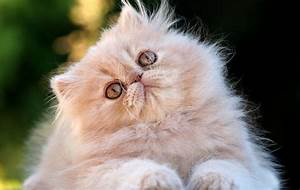

In [53]:
from PIL import Image
import IPython.display as display
import os

file_paths = [] # file_paths for targets
targets = [] # targets

# Parse animal folder and set file_path and targets arrays
for animal in animals:
    animal_dir = os.path.join(directory,animal)
    for file in os.listdir(animal_dir):
        file_paths.append(os.path.join(animal_dir, file))
        targets.append(animal)

print('Picture of', targets[0])
display.display(Image.open(file_paths[0]))

* This is great, but it was a lot of work to do all of this manually, Keras and Tensorflow make it easy

### Loading Images using Keras
* Keras comes with the ability to load images and the Tensorflow website [here](https://www.tensorflow.org/tutorials/load_data/images) has a bunch of great examples on implementation

In [54]:
import tensorflow as tf
import numpy as np
# The 1./255 is to convert from uint8 to float32 in range [0,1]
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

image_count = len(file_paths)
BATCH_SIZE = 32 # 32 for visualization, but 256 is typical for large scale image applications
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = img_gen.flow_from_directory(directory=str(directory), 
                                             follow_links=True,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = (animals))

Found 26179 images belonging to 10 classes.


The code above is pretty straightforward, the keras ImageDataGenerator utility provides an easy way to rescale and load images from paths. However one thing I do want to note is a very useful feature for directories with hierarchies.

In the event that you have folders within folders containing images, i.e: animals/cats/... and animals/dogs/..., you want to pay attention to:

**follow_links = True**

By default this is False, but setting it to True allows the DataGenerator to automatically loop through each individual directory according to the classes list

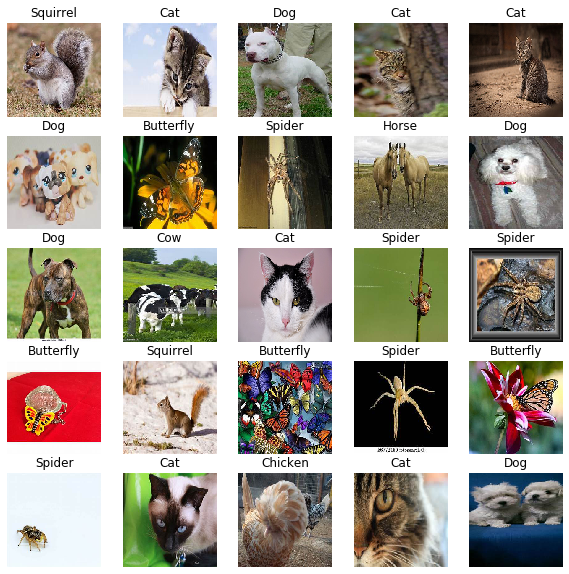

In [55]:
import matplotlib.pyplot as plt

# You need to turn the classes into a numpy array
animal_np = np.array(animals)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(animal_np[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

This method through Keras is great, but has a ton of problems:
1. Slow
2. No fine-grain control
3. Not integrated with TF directly (harder to troubleshoot when plugging into ConvNet)

### Loading images using tf.data

In [64]:
list_ds = tf.data.Dataset.list_files(str(directory + '/*/*')) # /*/* go down to the files

for f in list_ds.take(5):
  print(f.numpy())

b'animals/dog/OIP-PI72OVgnbpGuRo4qPXwOgQHaFj.jpeg'
b'animals/sheep/eb3cb00d20fc013ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg'
b'animals/squirrel/OIP-nO9vaILQGjpyvzPQedimvgHaE5.jpeg'
b'animals/chicken/OIP-Zs4a8yCEIX13DlwGm0EdOwHaFj.jpeg'
b'animals/cat/532.jpeg'


In [78]:
def decode_img(img):
  # convert the raw string into a 3d tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def get_label_image_pair(file_path):
    
    # Find the class name -----------------------------
    segments = tf.strings.split(file_path, os.path.sep)
    # The second to last is the directory name
    label = segments[-2]
    
    # Get the image in raw format ---------------------
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(get_label_image_pair) #num_parallel_calls=tf.data.experimental.AUTOTUNE)

labeled_ds = labeled_ds.shuffle(buffer_size=1000)
    
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  b'dog'


I'll be using the tensorflow.data method of loading images in order to make the process of image augmentation easier

## 1. Pre-processing and Data Augmentation
